In [1]:
using CSV, DataFrames, Plots, LaTeXStrings, DifferentialEquations, Optim

In [2]:
ddat = CSV.read("CSV/digitized.csv", DataFrame);
species = Array(ddat[!, 2:end]); t = ddat[!, :t]
Glost = CSV.read("CSV/G_noisy.csv", DataFrame; header=false)
Gl = Array(Glost); lostidx = length(t)-length(Gl)+1
species[lostidx:end, end] .= Gl
c_data = transpose(Float64.(species));

In [3]:
function kinetic_model!(du, u, p, t)
    cA, cB, cC, cD, cE, cF, cG = u
    k1, k2, k3, k4, k5, k6 = p
    du[1] = - k1*cA - k4*cA - k5*cA*cE
    du[2] = k1*cA - k2*cB - k3*cB
    du[3] = k2*cB - k4*cC
    du[4] = k4*cA - k3*cD
    du[5] = k3*cB - k5*cA*cE
    du[6] = k5*cA*cE - k6*cF*cG^2
    du[7] = - k6*cF*cG^2
end;

u0 = [0.5, 0.0, 0.0, 0.01, 0.0, 0.3, 0.5]
tspan = (0.0, 20.0)
p = [0.3, 0.1, 0.1, 0.4, 0.02, 0.5]
prob = ODEProblem(kinetic_model!, u0, tspan, p);

In [4]:
function RMSE(p, training_data; prob=prob, t=t)
    prob = remake(prob; p=p)
    ODE_output = convert(Array, solve(prob, saveat=t))
    err = training_data .- ODE_output
    sqrt(sum(err.^2))
end;

In [5]:
lower=fill(0.0, length(p))
upper=fill(1.0, length(p))
guess = lower .+ 1E-5
SAmIn = SAMIN(rt=0.01, verbosity=0)
options = Optim.Options(iterations=10^6)
cf(p) = RMSE(p, c_data);

In [6]:
res = Optim.optimize(cf, lower, upper, guess, SAmIn, options)
optim_p = Optim.minimizer(res)
for (kᵢ, i) in zip(["k₁", "k₂", "k₃", "k₄", "k₅", "k₆"], 1:6)
    printstyled("$(kᵢ) = $(round(optim_p[i], digits=3))\n";  color=:blue)
end

k₁ = 0.301
k₂ = 0.105
k₃ = 0.097
k₄ = 0.378
k₅ = 0.0
k₆ = 0.526


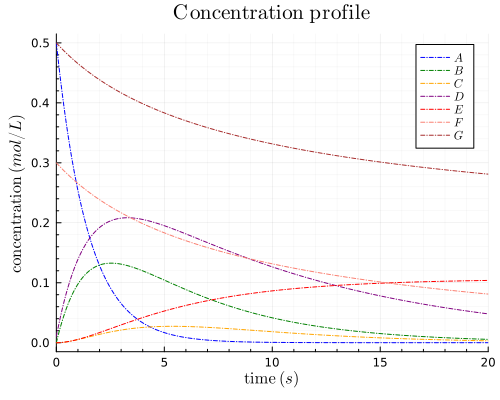

In [7]:
sol = solve(remake(prob; p=optim_p));
plot(sol, ls=:dashdot, label=[L"A" L"B" L"C" L"D" L"E" L"F" L"G"],
     color=[:blue :green :orange :purple :red :salmon :brown])
plot!(xlabel=L"$\mathrm{time}\,\,(s)$", ylabel=L"$\mathrm{concentration}\,\,(mol/L)$",
      minorgrid=true, size=(500,400))
plot!(title=L"$\mathrm{Concentration\,\,profile}$")

In [8]:
colors = [:blue :green :orange :purple :red :salmon :brown]
labels = [L"A" L"B" L"C" L"D" L"E" L"F" L"G"]
plot(sol, ls=:solid, label=labels, color=colors)
scatter!(t, species, markersize=0.2, marker=:circle, markerstrokecolor=colors,
       label=false, color=colors)
plot!(t, species, ls=:dot, lw=0.2, color=colors, label=false)
plot!(xlabel=L"$\mathrm{time}\,\,(s)$", ylabel=L"$\mathrm{concentration}\,\,(mol/L)$",
     minorgrid=true, size=(600,500))
plot!(title=L"$\mathrm{Concentration\,\,profile:Fitted\,\,ODE\,\,model}$")

***